# Import Tensorflow package

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# Installing wandb library which helps in displaying the clear progres-in bar visualization

In [ ]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     \ 10.4 MB 2.4 MB/s
     |████████████████████████████████| 180 kB 5.1 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 139 kB 55.9 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 70 kB 7.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=e62347187106e038dff25b80fab55c8dd91c1de1ec4af44ceabafcac80978e12
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=1ea054212a14892fe002fa9d0cff719a8585f899268d8435d7cb13259e54b82e
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=62dfb31e0e119928db941cbee5d93

# Importing wandb library and authenticating using API key for further calls

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Importing packages

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Loading Imagenet Dataset (5 Categories) 

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 38.49 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Loading the train and test Images from the cloned directory

In [ ]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


# Function is defined to apply resizing, scaling and converting images to numpy arrays. The image's corresponding labels are also assigned to numpy arrays

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

# The prepare_images function is applied to both training and test dataset and the progress is displayed with the help of wandb library

In [ ]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

100%|██████████| 1250/1250 [00:07<00:00, 166.55it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 170.27it/s]


(250, 224, 224, 3) (250,)


# Categories are encoded to numerical values using LabelEncoder

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# tensors are created from training and test dataset numpy arrays (both images and labels)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Define function to load RESNET-18 architecture without the fully connected neural network layer <br>

# Replaced the existing fully connected layer with two layers and manually defined the following fc layers <br><br>


# First Layer - Takes the output of encoding features of RESNET architecture & outputs 256 neurons, followed by ReLU activation function <br>
# Second Layer - Takes 256 features as input and outputs 5 neurons, followed by softmax activation function <br>



In [ ]:
def get_resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=False)
    pooled_features = GlobalAveragePooling2D()(features)

    pooled_features = Dense(256)(pooled_features)
    pooled_features = Activation("relu")(pooled_features)
    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

# Function is defined to plot the Training loss and Accuracy for generating representation using Simclr 

In [ ]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)


# Printing the Simclr built architecture summary

In [ ]:
get_resnet().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
____________________________________________

# sparse_categorical_crossentropy is used to reduce the loss for learning better representations in tensorflow implementation of Simclr. <br> <br>

# It helps in the two variations of single image  to generate representations that have higher  similarity for those two variation images and have lower  similarity between each of the variation image and other images in the dataset.

# plot_training function is called to record the training loss & accuracy

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/50
20/20 [==============================] - 777s 39s/step - loss: 1.9732 - accuracy: 0.2152 - val_loss: 1.5685 - val_accuracy: 0.3400


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
20/20 [==============================] - 763s 38s/step - loss: 1.6144 - accuracy: 0.2168 - val_loss: 1.6093 - val_accuracy: 0.2000
Epoch 3/50
20/20 [==============================] - 761s 38s/step - loss: 1.6095 - accuracy: 0.2000 - val_loss: 1.6037 - val_accuracy: 0.2360
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


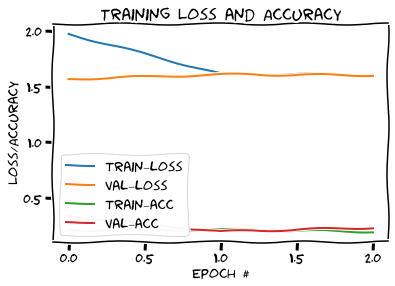

In [ ]:
wandb.init(project="simclr-tensorflow", id="supervised-training-evaluation")

model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[es, WandbCallback()])
plot_training(history)